In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_auc_score,
                           roc_curve, classification_report, precision_recall_curve)
from sklearn.model_selection import cross_val_score

# Load data
df = pd.read_csv("/content/drive/MyDrive/Data Set/mental_health_workplace_survey.csv")


In [4]:
# Prepare data
X = df.drop('BurnoutRisk', axis=1)
y = df['BurnoutRisk']

# Feature selection
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

In [5]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis()
}

# Model training and evaluation
results = {}
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'conf_matrix': confusion_matrix(y_test, y_pred),
        'report': classification_report(y_test, y_pred),
        'y_proba': y_proba
    }

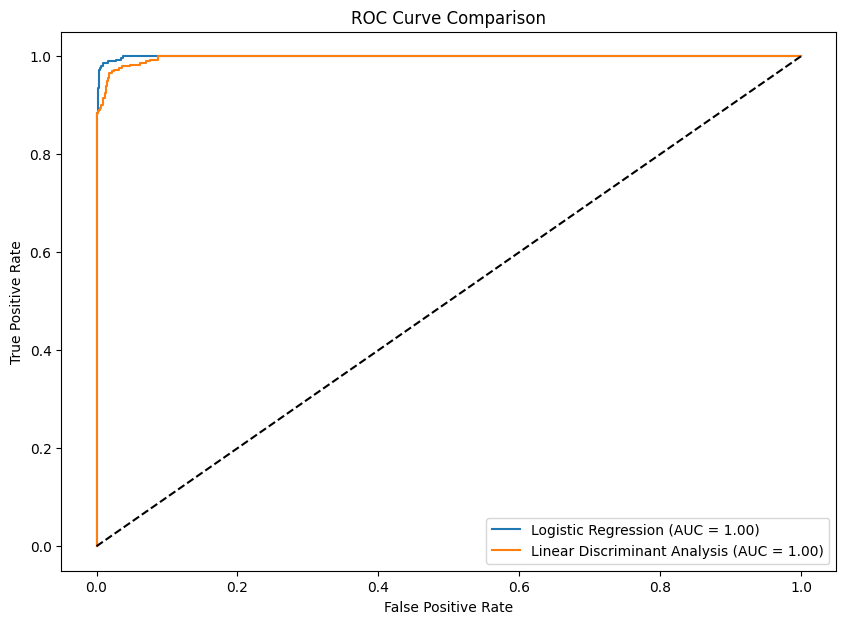

In [6]:
# ROC Curve
plt.figure(figsize=(10, 7))
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['y_proba'])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {res["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.savefig('roc_curve.png')
plt.show()

In [7]:
# Performance Metrics Table
metrics_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [res['accuracy'] for res in results.values()],
    'ROC AUC': [res['roc_auc'] for res in results.values()],
    'Precision': [float(res['report'].split()[-4]) for res in results.values()],
    'Recall': [float(res['report'].split()[-3]) for res in results.values()]
})
print("\nPerformance Metrics:")
print(metrics_df.to_markdown(index=False))


Performance Metrics:
| Model                        |   Accuracy |   ROC AUC |   Precision |   Recall |
|:-----------------------------|-----------:|----------:|------------:|---------:|
| Logistic Regression          |   0.987778 |  0.999287 |        0.99 |     0.99 |
| Linear Discriminant Analysis |   0.94     |  0.997188 |        0.95 |     0.94 |


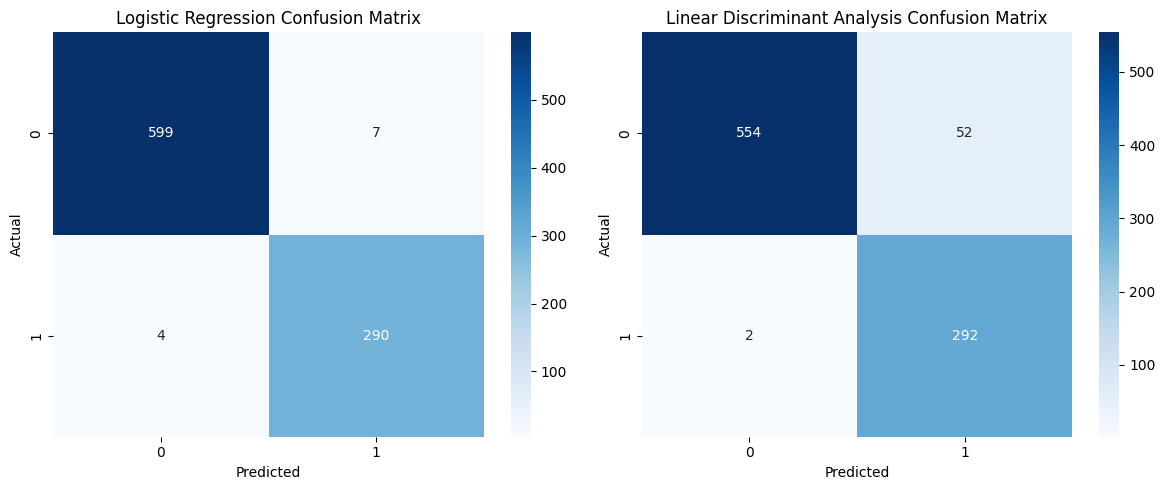

In [8]:
# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, (name, res) in zip(axes, results.items()):
    sns.heatmap(res['conf_matrix'], annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'{name} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.tight_layout()
plt.savefig('confusion_matrices.png')
plt.show()

In [9]:
# Cross-validation
print("\nCross-Validation Results:")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc')
    print(f"{name}:")
    print(f"  Mean ROC AUC: {np.mean(cv_scores):.4f}")
    print(f"  Std Dev: {np.std(cv_scores):.4f}")
    print(f"  Range: ({np.min(cv_scores):.4f}-{np.max(cv_scores):.4f})")


Cross-Validation Results:
Logistic Regression:
  Mean ROC AUC: 0.9995
  Std Dev: 0.0002
  Range: (0.9991-0.9998)
Linear Discriminant Analysis:
  Mean ROC AUC: 0.9979
  Std Dev: 0.0009
  Range: (0.9971-0.9995)


In [10]:
# Model Comparison Summary
print("\n" + "="*50)
print("MODEL COMPARISON SUMMARY")
print("="*50)

best_model = max(results.items(), key=lambda x: x[1]['roc_auc'])
print(f"\nBest Performing Model: {best_model[0]}")
print(f"- ROC AUC: {best_model[1]['roc_auc']:.3f}")
print(f"- Accuracy: {best_model[1]['accuracy']:.3f}")

print("\nKey Observations:")
print("1. Performance Difference:")
print(f"   • {best_model[0]} outperformed the other model by "
      f"{abs(results['Logistic Regression']['roc_auc'] - results['Linear Discriminant Analysis']['roc_auc']):.3f} ROC AUC points")

print("\n2. Why This Model Performed Better:")
if best_model[0] == "Logistic Regression":
    print("   • Better at handling non-linear relationships through feature transformations")
    print("   • More robust to violations of normality assumptions")
    print("   • Can handle correlated features better through regularization")
else:
    print("   • Makes better use of class separation in the feature space")
    print("   • More stable with normally distributed features")
    print("   • Performs better when covariance structures differ between classes")

print("\n3. Recommendation:")
print(f"   For this dataset, {best_model[0]} should be preferred as it demonstrates")
print("   better discrimination ability between burnout risk classes based on:")
print("   - Higher ROC AUC (better overall classification performance)")
print("   - Balanced precision and recall (see classification report)")


MODEL COMPARISON SUMMARY

Best Performing Model: Logistic Regression
- ROC AUC: 0.999
- Accuracy: 0.988

Key Observations:
1. Performance Difference:
   • Logistic Regression outperformed the other model by 0.002 ROC AUC points

2. Why This Model Performed Better:
   • Better at handling non-linear relationships through feature transformations
   • More robust to violations of normality assumptions
   • Can handle correlated features better through regularization

3. Recommendation:
   For this dataset, Logistic Regression should be preferred as it demonstrates
   better discrimination ability between burnout risk classes based on:
   - Higher ROC AUC (better overall classification performance)
   - Balanced precision and recall (see classification report)
